# Ariel Data Challenge 2025: Introductory model: training
Credita : @AmbrosM - This notebook is based on ADC24 Intro training ⭐️⭐️⭐️⭐️⭐️

In this notebook, we show how to train and cross-validate a model. At the end, we save the model so that it can be used for inference.

In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm
import pickle

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# A look at the data

We start by reading the metadata:

In [2]:
import os
import pandas as pd
from glob import glob
from collections import defaultdict
import numpy as np

# --- Load CSVs ---
train_df = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train.csv')
wavelengths_df = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')
train_star_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train_star_info.csv')

# --- 1. Basic Train Set Stats ---
print("🪐 Number of training planets:", train_df.shape[0])
print("📈 Number of target labels (wavelengths):", train_df.shape[1] - 1)
print("🔬 Length of wavelength grid:", wavelengths_df.shape[0])

# --- 2. Target Stats (per flux column) ---
target_cols = [col for col in train_df.columns if col != 'planet_id']
flux_summary = train_df[target_cols].agg(['min', 'max', 'mean', 'std']).T
print("\n📊 Flux value summary (first 5 rows):")
print(flux_summary.head())

# --- 3. Unique Stars ---
if 'planet_id' in train_star_info.columns:
    num_stars = train_star_info.drop(columns='planet_id').drop_duplicates().shape[0]
else:
    num_stars = train_star_info.drop_duplicates().shape[0]
print("\n🌟 Number of unique stars in training:", num_stars)

# --- 4. Planets with Multiple Observations ---
obs_counts = defaultdict(int)
train_planets = os.listdir('/kaggle/input/ariel-data-challenge-2025/train')

for pid in train_planets:
    air_obs = glob(f"train/{pid}/AIRS-CH0_signal_*.parquet")
    obs_counts[pid] = len(air_obs)

multi_obs = {pid: count for pid, count in obs_counts.items() if count > 1}
print("\n🔁 Planets with multiple observations:", len(multi_obs))

# --- 5. Check Calibration File Coverage ---
missing_calibs = []
expected = {"dark", "dead", "flat", "linear_corr", "read"}

for pid in train_planets:
    for band in ["AIRS-CH0", "FGS1"]:
        calib_path = f"train/{pid}/{band}_calibration"
        calib_files = {os.path.splitext(f)[0] for f in os.listdir(calib_path)} if os.path.exists(calib_path) else set()
        missing = expected - calib_files
        if missing:
            missing_calibs.append((pid, band, missing))

print("\n🧪 Planets missing calibration files:", len(missing_calibs))
if missing_calibs:
    print("   Example:", missing_calibs[0])

# --- 6. Optional: Distribution of Observations Per Planet ---
obs_distribution = pd.Series(list(obs_counts.values())).value_counts().sort_index()
print("\n🗂 Observation count distribution per planet (AIR-CH0):")
print(obs_distribution)

# --- 7. Planet-Star Uniqueness Check ---
merged = pd.merge(train_df[['planet_id']], train_star_info, on='planet_id', how='left')
unique_links = merged[['planet_id'] + [col for col in train_star_info.columns if col != 'planet_id']].drop_duplicates()
print("\n🔗 Unique planet-star mappings:", unique_links.shape[0])


🪐 Number of training planets: 1100
📈 Number of target labels (wavelengths): 283
🔬 Length of wavelength grid: 1

📊 Flux value summary (first 5 rows):
           min       max      mean       std
wl_1  0.003654  0.079797  0.014609  0.010652
wl_2  0.003668  0.077146  0.014588  0.010579
wl_3  0.003668  0.077210  0.014583  0.010574
wl_4  0.003667  0.077020  0.014578  0.010568
wl_5  0.003667  0.076574  0.014573  0.010561

🌟 Number of unique stars in training: 1100

🔁 Planets with multiple observations: 0

🧪 Planets missing calibration files: 2200
   Example: ('1253730513', 'AIRS-CH0', {'linear_corr', 'read', 'dead', 'dark', 'flat'})

🗂 Observation count distribution per planet (AIR-CH0):
0    1100
Name: count, dtype: int64

🔗 Unique planet-star mappings: 1100


# Key Dataset Insights (Ariel 2025)


- There are 1100 training planets, each corresponding to a unique star.

- Each planet has 283 target labels, representing spectral flux values.

- The wavelength grid has 1 shared configuration across all targets.

- All 1100 stars are unique — one per planet.

- Each planet is mapped to exactly one star (1100 unique planet-star pairs).

- There are no repeated observations per planet.

- A total of 2200 calibration file sets are missing (e.g., both AIRS-CH0 and FGS1 missing for each planet).

- Example: Planet 1253730513 is missing all five calibration files in AIRS-CH0.

- Flux values show low variability with means around 0.0146 and standard deviations around 0.0105 for the first 5 wavelengths.

- Observation count per planet (AIR-CH0) is 0 for all planets — signal files are not present in the current training directory.

In [3]:
train_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/adc_info.csv')
# test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
#                            index_col='planet_id')
train_labels = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train.csv',
                           index_col='planet_id')
wavelengths = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')
axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2025/axis_info.parquet')


## The FGS1 data

Having read the metadata, we'll tackle the FGS1 data (Fine Guidance System). The FGS1 measurements consist of one file per planet (673 files for 673 planets for training). For now, we ignore the calibration files.

Each file contains 135,000 rows of images taken at 0.1 second time steps. Each row is a 32\*32 image at a single wavelength.

We read a sample file:

In [4]:
planet_id = 1010375142
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')
f_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_1014,column_1015,column_1016,column_1017,column_1018,column_1019,column_1020,column_1021,column_1022,column_1023
0,433,426,436,431,430,432,442,431,442,435,...,432,437,435,433,449,430,439,435,433,431
1,445,443,438,441,437,442,435,437,435,434,...,451,439,442,443,439,437,427,433,439,435
2,448,431,442,444,439,435,432,431,441,448,...,439,437,440,439,441,441,435,432,436,442
3,454,440,440,436,433,433,443,436,429,442,...,439,445,438,437,438,439,443,435,444,441
4,447,441,431,441,442,434,434,435,442,443,...,438,431,424,436,449,446,438,440,429,438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134995,431,439,440,450,448,446,448,431,432,438,...,436,446,441,435,435,430,433,441,439,432
134996,444,439,426,426,439,434,429,441,442,429,...,436,444,447,434,445,433,440,433,436,431
134997,446,446,448,433,442,437,448,436,441,436,...,429,440,441,439,434,437,435,436,446,431
134998,435,436,433,439,440,434,436,440,442,432,...,440,430,430,436,431,438,441,435,441,446


Every row of the file corresponds to an image of a star. The images come in pairs, and the second image is lighter than the first one:

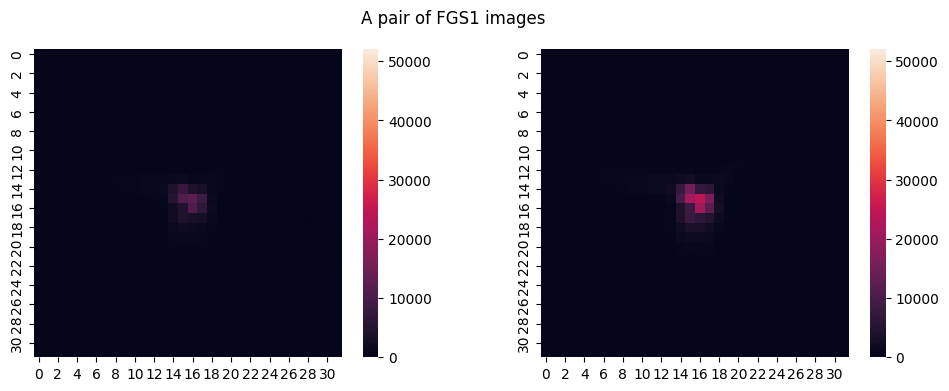

In [5]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(f_signal.iloc[0].values.reshape(32, 32), ax=ax1, vmin=0, vmax=52000)
ax1.set_aspect('equal')
sns.heatmap(f_signal.iloc[1].values.reshape(32, 32), ax=ax2, vmin=0, vmax=52000)
ax2.set_aspect('equal')
plt.suptitle('A pair of FGS1 images')
plt.show()

To see the time series, we first have to compute the difference between the even and the odd frames to get the net signal (67500 time steps). We then take the mean over all 1024 pixels. The net signal is very noisy, and we smoothen it by computing a moving average. The plot of the smoothened signal clearly shows that the signal intensity is reduced (i.e., the image gets darker) while the planet passes in front of the star (between time steps 23500 and 44000).

The left diagram shows a planet with a strong reduction of the signal intensity, the right diagram shows a planet with a weak reduction:

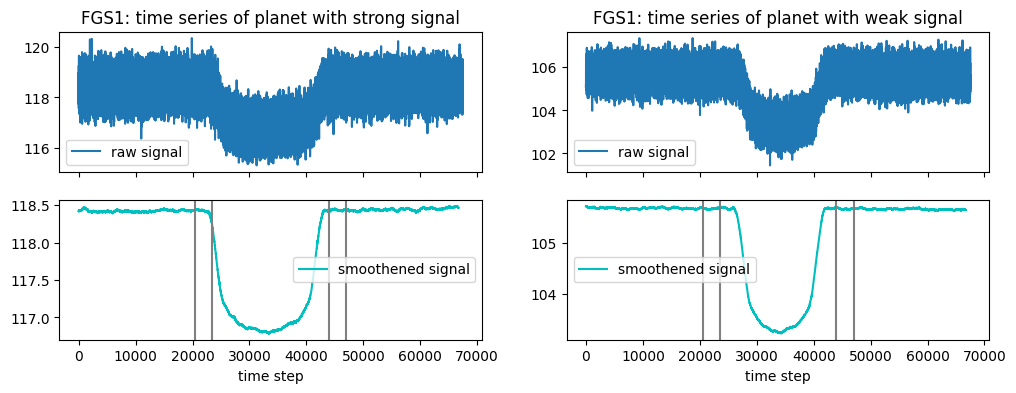

In [6]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(12, 4))

planet_id = 1048114509
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')

mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=800
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

ax1.set_title('FGS1: time series of planet with strong signal')
ax1.plot(net_signal, label='raw signal')
ax1.legend()
ax3.plot(smooth_signal, color='c', label='smoothened signal')
ax3.legend()
ax3.set_xlabel('time step')
for time_step in [20500, 23500, 44000, 47000]:
    ax3.axvline(time_step, color='gray')

planet_id = 1240764363
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')

mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=800
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

ax2.set_title('FGS1: time series of planet with weak signal')
ax2.plot(net_signal, label='raw signal')
ax2.legend()
ax4.plot(smooth_signal, color='c', label='smoothened signal')
ax4.legend()
ax4.set_xlabel('time step')
for time_step in [20500, 23500, 44000, 47000]:
    ax4.axvline(time_step, color='gray')

# plt.suptitle('FGS1 time series', y=0.96)
plt.show()

## The AIRS data

AIRS is the other sensor of the satellite. It produces one file per planet as well. Each file contains 11,250 rows of images captured at constant time steps. Each 32 x 356 image has been flattened into 11392 columns.

In [7]:
planet_id = 1240764363
a_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/AIRS-CH0_signal_0.parquet')
a_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_11382,column_11383,column_11384,column_11385,column_11386,column_11387,column_11388,column_11389,column_11390,column_11391
0,432,438,433,429,440,442,434,441,437,426,...,439,435,436,434,440,433,435,432,438,434
1,433,433,426,437,441,441,439,439,432,435,...,445,438,447,446,447,428,452,433,439,426
2,438,445,433,441,435,445,440,433,443,435,...,449,437,441,430,438,424,436,444,440,443
3,431,441,433,437,432,432,436,446,441,431,...,447,448,438,451,438,439,444,448,444,436
4,437,434,427,436,438,428,429,439,443,439,...,446,441,440,440,436,444,435,445,443,428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,431,432,447,436,439,431,443,440,433,442,...,443,441,443,440,442,457,435,433,457,426
11246,435,441,447,428,441,435,429,442,444,434,...,427,437,433,440,438,442,434,437,442,440
11247,441,451,439,439,443,444,447,441,440,439,...,447,443,448,438,446,446,448,443,446,437
11248,428,433,434,446,435,439,436,431,450,435,...,441,434,451,432,443,446,447,438,437,440


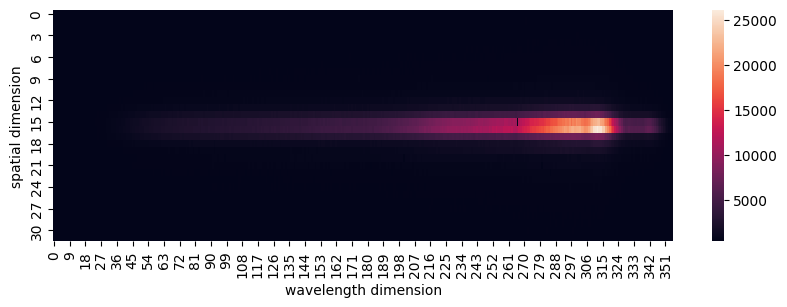

In [8]:
a_signal = a_signal.values.reshape(11250, 32, 356)

plt.figure(figsize=(10, 3))
sns.heatmap(a_signal[1])
plt.ylabel('spatial dimension')
plt.xlabel('wavelength dimension')
plt.show()

The data again is a time series, and we can see how the star is obscured while the planet is passing in front of it.

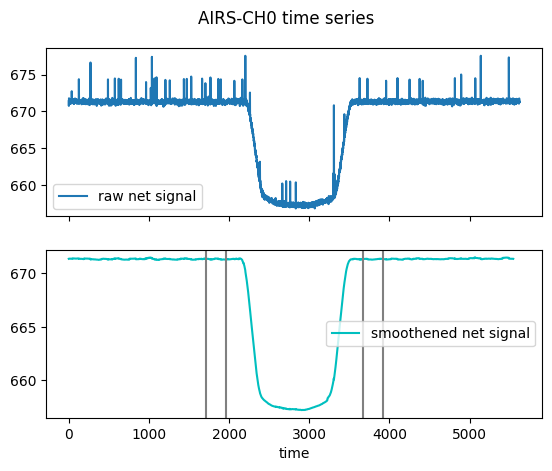

In [9]:
mean_signal = a_signal.mean(axis=2).mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=80
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(net_signal, label='raw net signal')
ax1.legend()
ax2.plot(smooth_signal, color='c', label='smoothened net signal')
ax2.legend()
ax2.set_xlabel('time')
for time_step in [20500, 23500, 44000, 47000]:
    ax2.axvline(time_step * 11250 // 135000, color='gray')
plt.suptitle('AIRS-CH0 time series', y=0.96)
plt.show()


# Reading the data

We now read the FGS1 data and the AIRS-CH0 data for all 1100 training planets. We keep only two one-dimensional time series for every planet. At the end we'll have
1. A time series with 67500 steps per planet taken from the FGS1 data, and
2. A time series with 5625 steps per planet taken from the AIRS-CH0 data.

We use the Jupyter `%%writefile` cell magic to save the function code to a file. This ensures that the inference notebook will process the test data in exactly the same way as this notebook processes the training data.

In [10]:
%%writefile f_read_and_preprocess.py

def f_read_and_preprocess(dataset, adc_info, planet_ids):
    """Read the FGS1 files for all planet_ids and extract the time series.
    
    Parameters
    dataset: 'train' or 'test'
    adc_info: metadata dataframe, either train_adc_info or test_adc_info
    planet_ids: list of planet ids
    
    Returns
    dataframe with one row per planet_id and 67500 values per row
    
    """
    f_raw_train = np.full((len(planet_ids), 67500), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        f_signal = pl.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/{dataset}/{planet_id}/FGS1_signal_0.parquet')
        mean_signal = f_signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / 1024 # mean over the 32*32 pixels
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        f_raw_train[i] = net_signal
    return f_raw_train
    

Writing f_read_and_preprocess.py


In [11]:
%%time
exec(open('f_read_and_preprocess.py', 'r').read())
f_raw_train = f_read_and_preprocess('train', train_adc_info, train_labels.index)
with open('f_raw_train.pickle', 'wb') as f:
    pickle.dump(f_raw_train, f)


100%|██████████| 1100/1100 [15:18<00:00,  1.20it/s]


CPU times: user 25min 37s, sys: 4min 33s, total: 30min 10s
Wall time: 15min 18s


In [12]:
%%writefile a_read_and_preprocess.py
def a_read_and_preprocess(dataset, adc_info, planet_ids):
    """Read the AIRS-CH0 files for all planet_ids and extract the time series.
    
    Parameters
    dataset: 'train' or 'test'
    adc_info: metadata dataframe, either train_adc_info or test_adc_info
    planet_ids: list of planet ids
    
    Returns
    dataframe with one row per planet_id and 5625 values per row
    
    """
    a_raw_train = np.full((len(planet_ids), 5625), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        signal = pl.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/{dataset}/{planet_id}/AIRS-CH0_signal_0.parquet')
        mean_signal = signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / (32*356) # mean over the 32*356 pixels
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        a_raw_train[i] = net_signal
    return a_raw_train
    

Writing a_read_and_preprocess.py


In [13]:
%%time
exec(open('a_read_and_preprocess.py', 'r').read())
a_raw_train = a_read_and_preprocess('train', train_adc_info, train_labels.index)
with open('a_raw_train.pickle', 'wb') as f:
    pickle.dump(a_raw_train, f)


100%|██████████| 1100/1100 [17:20<00:00,  1.06it/s]

CPU times: user 32min 7s, sys: 3min 7s, total: 35min 14s
Wall time: 17min 20s


As a plausibility check, we plot the means of all time series:

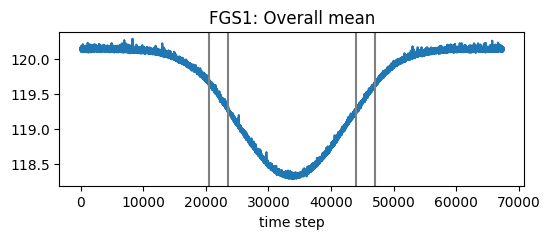

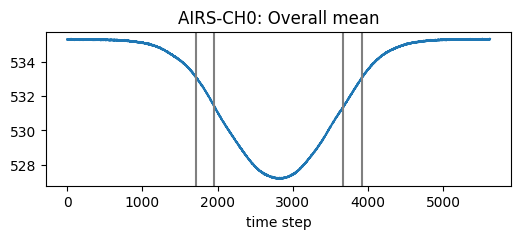

In [14]:
plt.figure(figsize=(6, 2))
plt.plot(f_raw_train.mean(axis=0))
for time_step in [20500, 23500, 44000, 47000]:
    plt.axvline(time_step, color='gray')
plt.xlabel('time step')
plt.title('FGS1: Overall mean')
plt.show()

plt.figure(figsize=(6, 2))
plt.plot(a_raw_train.mean(axis=0))
for time_step in [20500, 23500, 44000, 47000]:
    plt.axvline(time_step * 11250 // 135000, color='gray')
plt.xlabel('time step')
plt.title('AIRS-CH0: Overall mean')
plt.show()

# Feature engineering

We want to know how much darker the images get when the planet obscures the star. The time series diagrams above show that the planets reduce the brightness of the stars (on average) by 0.2 % (from 228.2 to 227.6 or from 1371 to 1368).

In [15]:
%%writefile feature_engineering.py

def feature_engineering(f_raw, a_raw):
    """Create a dataframe with two features from the raw data.
    
    Parameters:
    f_raw: ndarray of shape (n_planets, 67500)
    a_raw: ndarray of shape (n_planets, 5625)
    
    Return value:
    df: DataFrame of shape (n_planets, 2)
    """
    obscured = f_raw[:, 23500:44000].mean(axis=1)
    unobscured = (f_raw[:, :20500].mean(axis=1) + f_raw[:, 47000:].mean(axis=1)) / 2
    f_relative_reduction = (unobscured - obscured) / unobscured
    obscured = a_raw[:, 1958:3666].mean(axis=1)
    unobscured = (a_raw[:, :1708].mean(axis=1) + a_raw[:, 3916:].mean(axis=1)) / 2
    a_relative_reduction = (unobscured - obscured) / unobscured

    df = pd.DataFrame({'a_relative_reduction': a_relative_reduction,
                       'f_relative_reduction': f_relative_reduction})
    
    return df


Writing feature_engineering.py


In [16]:
exec(open('feature_engineering.py', 'r').read())

train = feature_engineering(f_raw_train, a_raw_train)

# The model and the cross-validation

To keep things simple, we predict the targets with ridge regression.

We are interested in three cross-validation metrics:
1. The R2 score is above 0.9, which confirms the correlation we've seen in the scatterplot.
2. The root mean squared error will be the predicted uncertainty.
3. The competition metric gives an indication of the leaderboard score. Unfortunately the competition metric depends on the value of `sigma_true`, which I don't know.

In [17]:
model = Ridge(alpha=1e-12)

oof_pred = cross_val_predict(model, train, train_labels)

print(f"# R2 score: {r2_score(train_labels, oof_pred):.3f}")
sigma_pred = mean_squared_error(train_labels, oof_pred, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")
# R2 score: 0.971
# Root mean squared error: 0.000293

# R2 score: 0.882
# Root mean squared error: 0.003668


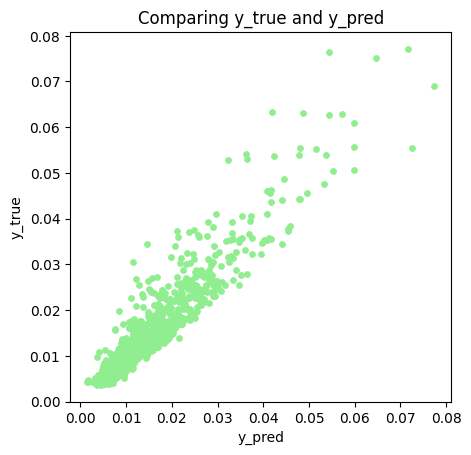

In [18]:
col = 1
plt.scatter(oof_pred[:,col], train_labels.iloc[:,col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

In [19]:
%%writefile competition_score.py
# Adapted from https://www.kaggle.com/code/metric/ariel-gaussian-log-likelihood

# Custom error for invalid submissions
class ParticipantVisibleError(Exception):
    pass

def competition_score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    naive_mean: float,
    naive_sigma: float,
    sigma_true: float,
    row_id_column_name='planet_id'
) -> float:
    '''
    Computes a Gaussian Log Likelihood-based score.
    '''
    # Drop ID columns
    solution = solution.drop(columns=[row_id_column_name], errors='ignore')
    submission = submission.drop(columns=[row_id_column_name], errors='ignore')

    # Validation checks
    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')

    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be numeric: {col}')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != 2 * n_wavelengths:
        raise ParticipantVisibleError('Submission must have 2x columns of the solution')

    # Extract predictions and sigmas
    y_pred = submission.iloc[:, :n_wavelengths].values
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=1e-15, a_max=None)
    y_true = solution.values

    # Compute log likelihoods
    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean, scale=naive_sigma))

    score = (GLL_pred - GLL_mean) / (GLL_true - GLL_mean)
    return float(np.clip(score, 0.0, 1.0))

Writing competition_score.py


In [20]:


def postprocessing(pred_array, index, sigma_pred, column_names=None):
    """
    Creates a submission DataFrame with mean predictions and uncertainties.

    Parameters:
    - pred_array: ndarray of shape (n_samples, 283)
    - index: pandas.Index of length n_samples
    - sigma_pred: float or ndarray of shape (n_samples, 283)
    - column_names: list of wavelength column names (optional)

    Returns:
    - df: DataFrame of shape (n_samples, 566)
    """
    n_samples, n_waves = pred_array.shape

    if column_names is None:
        column_names = [f"wl_{i+1}" for i in range(n_waves)]

    if np.isscalar(sigma_pred):
        sigma_pred = np.full_like(pred_array, sigma_pred)

    # Safety check
    assert sigma_pred.shape == pred_array.shape, "sigma_pred must match shape of pred_array"
    assert len(index) == n_samples, "Index length must match number of rows"

    df_mean = pd.DataFrame(pred_array.clip(0, None), index=index, columns=column_names)
    df_sigma = pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i+1}" for i in range(n_waves)])

    return pd.concat([df_mean, df_sigma], axis=1)

In [21]:
exec(open('competition_score.py', 'r').read())
#exec(open('postprocessing.py', 'r').read())

oof_df = postprocessing(oof_pred, train_labels.index, sigma_pred)
display(oof_df)

gll_score = competition_score(train_labels.copy().reset_index(),
                              oof_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.000003)
print(f"# Estimated competition score: {gll_score:.3f}")
# Estimated competition score: 0.123

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
34983,0.021673,0.020617,0.020616,0.020604,0.020589,0.020573,0.020557,0.020540,0.020525,0.020513,...,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668
1873185,0.008636,0.008472,0.008472,0.008469,0.008467,0.008467,0.008468,0.008470,0.008470,0.008470,...,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668
3849793,0.041463,0.040985,0.040970,0.040948,0.040922,0.040891,0.040855,0.040821,0.040792,0.040768,...,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668
8456603,0.011597,0.011848,0.011844,0.011841,0.011838,0.011837,0.011836,0.011837,0.011837,0.011836,...,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668
23615382,0.018204,0.017837,0.017833,0.017825,0.017815,0.017805,0.017795,0.017786,0.017777,0.017770,...,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4290810553,0.022032,0.021617,0.021612,0.021602,0.021589,0.021575,0.021559,0.021544,0.021531,0.021519,...,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668
4291452525,0.025375,0.025412,0.025402,0.025390,0.025377,0.025361,0.025343,0.025326,0.025312,0.025299,...,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668
4291977477,0.008211,0.008642,0.008637,0.008636,0.008637,0.008640,0.008644,0.008650,0.008655,0.008657,...,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668,0.003668


# Estimated competition score: 0.123


# Refitting and saving the model

In [22]:
# Refit the model to the full dataset
model.fit(train, train_labels)
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)
with open('sigma_pred.pickle', 'wb') as f:
    pickle.dump(sigma_pred, f)

# Submission

In [23]:
import pandas as pd
import numpy as np
import pickle

# 1. Load required files
test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/test_star_info.csv', index_col='planet_id')
sample_submission = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/sample_submission.csv', index_col='planet_id')
wavelengths = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')

# 2. Load model and sigma
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)

with open('sigma_pred.pickle', 'rb') as f:
    sigma_pred = pickle.load(f)

# 3. Run your preprocessing + feature extraction on test set
# These must be implemented in your own code — you can adapt from training logic
f_raw_test = f_read_and_preprocess('test', test_adc_info, sample_submission.index)
a_raw_test = a_read_and_preprocess('test', test_adc_info, sample_submission.index)
test_features = feature_engineering(f_raw_test, a_raw_test)

# 4. Predict
test_pred = model.predict(test_features)

# 5. Postprocessing
def postprocessing(pred_array, index, sigma_pred, column_names):
    """
    Convert predictions and uncertainty into final submission DataFrame.
    """
    if np.isscalar(sigma_pred):
        sigma_array = np.full_like(pred_array, sigma_pred)
    else:
        sigma_array = sigma_pred
    df_pred = pd.DataFrame(pred_array.clip(0, None), index=index, columns=column_names)
    df_sigma = pd.DataFrame(sigma_array, index=index, columns=[f"sigma_{i}" for i in range(1, len(column_names)+1)])
    return pd.concat([df_pred, df_sigma], axis=1)

submission_df = postprocessing(
    pred_array=test_pred,
    index=sample_submission.index,
    sigma_pred=sigma_pred,
    column_names=wavelengths.columns
)

# 6. Save
submission_df.to_csv('submission.csv')

# 7. Preview
!head submission.csv


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,wl_11,wl_12,wl_13,wl_14,wl_15,wl_16,wl_17,wl_18,wl_19,wl_20,wl_21,wl_22,wl_23,wl_24,wl_25,wl_26,wl_27,wl_28,wl_29,wl_30,wl_31,wl_32,wl_33,wl_34,wl_35,wl_36,wl_37,wl_38,wl_39,wl_40,wl_41,wl_42,wl_43,wl_44,wl_45,wl_46,wl_47,wl_48,wl_49,wl_50,wl_51,wl_52,wl_53,wl_54,wl_55,wl_56,wl_57,wl_58,wl_59,wl_60,wl_61,wl_62,wl_63,wl_64,wl_65,wl_66,wl_67,wl_68,wl_69,wl_70,wl_71,wl_72,wl_73,wl_74,wl_75,wl_76,wl_77,wl_78,wl_79,wl_80,wl_81,wl_82,wl_83,wl_84,wl_85,wl_86,wl_87,wl_88,wl_89,wl_90,wl_91,wl_92,wl_93,wl_94,wl_95,wl_96,wl_97,wl_98,wl_99,wl_100,wl_101,wl_102,wl_103,wl_104,wl_105,wl_106,wl_107,wl_108,wl_109,wl_110,wl_111,wl_112,wl_113,wl_114,wl_115,wl_116,wl_117,wl_118,wl_119,wl_120,wl_121,wl_122,wl_123,wl_124,wl_125,wl_126,wl_127,wl_128,wl_129,wl_130,wl_131,wl_132,wl_133,wl_134,wl_135,wl_136,wl_137,wl_138,wl_139,wl_140,wl_141,wl_142,wl_143,wl_144,wl_145,wl_146,wl_147,wl_148,wl_149,wl_150,wl_151,wl_152,wl_153,wl_154,wl_155,wl_156,wl_157